In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

%load_ext autoreload
%autoreload 2
%load_ext line_profiler

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # adapt plots for retina displays
from IPython.core.debugger import set_trace

import utils

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [3]:
from tqdm import tqdm_notebook
import collections
import os
import random
import time
import math
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

In [4]:
import requests

def download_file_from_google_drive(id, destination):
    """
    Download a large file from Google Drive via a shared link.
    
    Large files cannot be downloaded from Google Drive via wget.
    From: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive
    """
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

# Datasets and Preprocessing

## FB15K-237

In [7]:
%%bash

# Download and unzip FB15K-237.
#cd ../data
#mkdir fb15k-237
#cd fb15k-237
#wget https://download.microsoft.com/download/8/7/0/8700516A-AB3D-4850-B4BB-805C515AECE1/FB15K-237.2.zip
#unzip FB15K-237.2.zip

In [5]:
fb_dir = '../data/fb15k-237/Release'

In [6]:
train_triples = pd.read_csv(os.path.join(fb_dir, 'train.txt'), sep='\t', names=['subject', 'relation', 'object'])
val_triples = pd.read_csv(os.path.join(fb_dir, 'valid.txt'), sep='\t', names=['subject', 'relation', 'object'])
test_triples = pd.read_csv(os.path.join(fb_dir, 'test.txt'), sep='\t', names=['subject', 'relation', 'object'])
print(len(train_triples), len(val_triples), len(test_triples))
train_triples.head()

272115 17535 20466


,subject,relation,object
0,/m/027rn,/location/country/form_of_government,/m/06cx9
1,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0
2,/m/07s9rl0,/media_common/netflix_genre/titles,/m/0170z3
3,/m/01sl1q,/award/award_winner/awards_won./award/award_ho...,/m/044mz_
4,/m/0cnk2q,/soccer/football_team/current_roster./sports/s...,/m/02nzb8


In [7]:
entity_map = utils.IndexMap(train_triples[['subject', 'object']], 
                            val_triples[['subject', 'object']], 
                            test_triples[['subject', 'object']])

relation_map = utils.IndexMap(train_triples['relation'], 
                              val_triples['relation'], 
                              test_triples['relation'])

# TODO: Maybe rename num_entities.
num_nodes = len(entity_map)
num_relations = len(relation_map)

num_nodes, num_relations

(14541, 237)

In [7]:
# TODO: Rename.
#feat_data = np.eye(num_nodes)

In [7]:
# For non-relational model.
# TODO: Refactor this to use a method similar to the relational model below.
adj_lists = collections.defaultdict(set)
for i, row in tqdm_notebook(train_triples.iterrows(), total=len(train_triples)):
    subject_index = entity_map.to_index(row['subject'])
    object_index = entity_map.to_index(row['object'])
    # Use non-directed edges here.
    adj_lists[subject_index].add(object_index)
    adj_lists[object_index].add(subject_index)

HBox(children=(IntProgress(value=0, max=272115), HTML(value=u'')))

KeyboardInterrupt: 

In [8]:
# For relational model.
def triples_to_array(df):
    subjects = df['subject'].map(entity_map.to_index)
    objects = df['object'].map(entity_map.to_index)
    relations = df['relation'].map(relation_map.to_index)
    return np.vstack([subjects, objects, relations]).T

train_triples_arr = triples_to_array(train_triples)
val_triples_arr = triples_to_array(val_triples)
test_triples_arr = triples_to_array(test_triples)

# Required for filtered ranking evaluation to check if corrupted triples appear anywhere in the dataset.
all_triples_arr = np.vstack([train_triples_arr, val_triples_arr, test_triples_arr])

print(len(train_triples_arr), len(val_triples_arr), len(test_triples_arr), len(all_triples_arr))
train_triples_arr

272115 17535 20466 310116


array([[ 3818,  8942,   122],
       [  819,  9234,   230],
       [ 9791,   756,   140],
       ...,
       [11737,  4042,   198],
       [12535,  9678,    13],
       [ 3203, 10433,    11]])

In [9]:
relational_adj_dict = collections.defaultdict(lambda: collections.defaultdict(list))
for s, o, r in train_triples_arr:  # only use training set, so the network does not implicilty see the whole graph
    relational_adj_dict[s][o].append(r)
    
# Count connections in relational_adj_dict. 
# Make sure that this number is euqivalent to the number of train triples.
np.sum([len(l) for d in relational_adj_dict.values() for l in d.values()]), len(train_triples)

(272115, 272115)

## FB15K-237: Numbers (Garcia-Duran et al. 2017)

In [49]:
%%bash

# Download numerical data from Garcia-Duran et al. (2017).
#cd data/fb15k-237
#wget https://raw.githubusercontent.com/nle-ml/mmkb/master/numTriples_FB15k.txt

In [47]:
numerical_features = pd.read_csv('data/fb15k-237/numTriples_FB15k.txt', sep='\t', names=['entity', 'attribute', 'value'])
numerical_features.head()

,entity,attribute,value
0,/m/06rf7,<http://rdf.freebase.com/ns/location.geocode.l...,9.704049e+00
1,/m/06rf7,<http://rdf.freebase.com/ns/location.geocode.l...,5.420868e+01
2,/m/06rf7,<http://rdf.freebase.com/ns/topic_server.popul...,2.837021e+06
3,/m/06rf7,<http://rdf.freebase.com/ns/location.location....,1.576318e+04
4,/m/04258w,<http://rdf.freebase.com/ns/people.person.date...,1.912667e+03


In [46]:
print('Entities in train set:', len(train_triples['subject'].unique()))
print('Entities with numerical features:', len(numerical_features['entity'].unique()))
print('Intersection (entities in train set with numerical features):', len(np.intersect1d(numerical_features['entity'].unique(), train_triples['subject'].unique())))

Entities in train set: 13781
Entities with numerical features: 12493
Intersection (entities in train set with numerical features): 12047


## FB15K-237: Numbers and texts (Kristiadi et al. 2018)

In [52]:
%%bash
#cd data/fb15k-237
#wget https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/numerical_literals.txt

--2018-03-05 14:44:55--  https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/numerical_literals.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5196154 (5.0M) [text/plain]
Saving to: 'numerical_literals.txt'

     0K .......... .......... .......... .......... ..........  0% 3.99M 1s
    50K .......... .......... .......... .......... ..........  1% 7.02M 1s
   100K .......... .......... .......... .......... ..........  2% 6.95M 1s
   150K .......... .......... .......... .......... ..........  3% 7.05M 1s
   200K .......... .......... .......... .......... ..........  4% 7.89M 1s
   250K .......... .......... .......... .......... ..........  5% 8.27M 1s
   300K .......... .......... .......... .......... ..........  6% 10.7M 1s
   350K .......... ....

In [53]:
numerical_features_kristiadi = pd.read_csv('data/fb15k-237/numerical_literals.txt', sep='\t', names=['entity', 'attribute', 'value'])
numerical_features_kristiadi.head()

,entity,attribute,value
0,/m/0265wl,http://rdf.freebase.com/ns/award.award_categor...,1965
1,/m/0n5c9,http://rdf.freebase.com/ns/location.location.area,1245.78428107
2,/m/0n5c9,http://rdf.freebase.com/ns/location.dated_loca...,1739
3,/m/0n5c9,http://rdf.freebase.com/ns/topic_server.popula...,462263
4,/m/0n5c9,http://rdf.freebase.com/ns/topic_server.popula...,482155


In [54]:
print('Entities in train set:', len(train_triples['subject'].unique()))
print('Entities with numerical features:', len(numerical_features_kristiadi['entity'].unique()))
print('Intersection (entities in train set with numerical features):', len(np.intersect1d(numerical_features_kristiadi['entity'].unique(), train_triples['subject'].unique())))

Entities in train set: 13781
Entities with numerical features: 9941
Intersection (entities in train set with numerical features): 9608


In [55]:
%%bash
#cd data/fb15k-237
#wget https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/text_literals.txt

--2018-03-05 14:46:55--  https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/text_literals.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12991982 (12M) [text/plain]
Saving to: 'text_literals.txt'

     0K .......... .......... .......... .......... ..........  0% 1.24M 10s
    50K .......... .......... .......... .......... ..........  0% 4.23M 6s
   100K .......... .......... .......... .......... ..........  1% 6.51M 5s
   150K .......... .......... .......... .......... ..........  1% 6.65M 4s
   200K .......... .......... .......... .......... ..........  1% 7.22M 4s
   250K .......... .......... .......... .......... ..........  2% 10.1M 3s
   300K .......... .......... .......... .......... ..........  2% 8.66M 3s
   350K .......... .......... ..

In [56]:
text_features_kristiadi = pd.read_csv('data/fb15k-237/text_literals.txt', sep='\t', names=['entity', 'attribute', 'value'])
text_features_kristiadi.head()

,entity,attribute,value
0,/m/03j9ml,http://rdf.freebase.com/ns/common.topic.descri...,Maggie Roswell is an American film and televis...
1,/m/05cws2,http://rdf.freebase.com/ns/common.topic.descri...,Halesowen Town is an English association footb...
2,/m/0qxzd,http://rdf.freebase.com/ns/common.topic.descri...,"Hayward is a city located in Alameda County, C..."
3,/m/01h18v,http://rdf.freebase.com/ns/common.topic.descri...,About Schmidt is a 2002 American comedy-drama ...
4,/m/0c4y8,http://rdf.freebase.com/ns/common.topic.descri...,"Thomas Lanier ""Tennessee"" Williams III was an ..."


In [59]:
print('Entities in train set:', len(train_triples['subject'].unique()))
print('Entities with text features:', len(text_features_kristiadi['entity'].unique()))
print('Intersection (entities in train set with text features):', len(np.intersect1d(text_features_kristiadi['entity'].unique(), train_triples['subject'].unique())))

Entities in train set: 13781
Entities with text features: 14886
Intersection (entities in train set with text features): 13754


## FB15K-237: Images (ImageGraph; Onoro-Rubio et al. 2017)

In [92]:
%%bash
#cd data/fb15k-237
#wget https://www.dropbox.com/s/thct96phmypkaon/image-graph_urls.tar.gz
#tar -xvzf image-graph_urls.tar.gz

--2018-03-12 14:04:52--  https://www.dropbox.com/s/thct96phmypkaon/image-graph_urls.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/ct8mncZqLggve46aNBpGZJ3KEH93mLyB6cpivrWAZImNFpywuiCyOlVYZn5HDjXT/file [following]
--2018-03-12 14:04:52--  https://dl.dropboxusercontent.com/content_link/ct8mncZqLggve46aNBpGZJ3KEH93mLyB6cpivrWAZImNFpywuiCyOlVYZn5HDjXT/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.65.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.65.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95528096 (91M) [application/octet-stream]
Saving to: 'image-graph_urls.tar.gz'

     0K .......... .......... .......... .......... ..........  0%  633K 2m27s
    50K .......... .......... .......... ...

In [164]:
# Download images via script `donwload-images.py`

## YAGO3-10

In [36]:
%%bash

# Download and unzip.
#cd ../data
#mkdir yago3-10
#cd yago3-10
#wget https://github.com/TimDettmers/ConvE/raw/master/YAGO3-10.tar.gz
#tar -xvf YAGO3-10.tar.gz

valid.txt
train.txt
test.txt


--2018-03-24 00:02:25--  https://github.com/TimDettmers/ConvE/raw/master/YAGO3-10.tar.gz
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TimDettmers/ConvE/master/YAGO3-10.tar.gz [following]
--2018-03-24 00:02:26--  https://raw.githubusercontent.com/TimDettmers/ConvE/master/YAGO3-10.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19314116 (18M) [application/octet-stream]
Saving to: 'YAGO3-10.tar.gz'

     0K .......... .......... .......... .......... ..........  0% 1.22M 15s
    50K .......... .......... .......... .......... ..........  0% 3.34M 10s
   100K .......... .......... .......... .......... .......

In [4]:
yago_dir = '../data/yago3-10'

In [5]:
train_triples = pd.read_csv(os.path.join(yago_dir, 'train.txt'), sep='\t', names=['subject', 'relation', 'object'])
val_triples = pd.read_csv(os.path.join(yago_dir, 'valid.txt'), sep='\t', names=['subject', 'relation', 'object'])
test_triples = pd.read_csv(os.path.join(yago_dir, 'test.txt'), sep='\t', names=['subject', 'relation', 'object'])
print(len(train_triples), len(val_triples), len(test_triples))
train_triples.head()

1079040 5000 5000


,subject,relation,object
0,Chatou,isLocatedIn,France
1,Boo_Young-tae,playsFor,Yangju_Citizen_FC
2,Toni_Kuivasto,isAffiliatedTo,Helsingin_Jalkapalloklubi
3,Josh_Smith_(soccer),playsFor,Trinity_University_(Texas)
4,Albrecht_Dürer,diedIn,Nuremberg


In [6]:
entity_map = utils.IndexMap(train_triples[['subject', 'object']], 
                            val_triples[['subject', 'object']], 
                            test_triples[['subject', 'object']])

relation_map = utils.IndexMap(train_triples['relation'], 
                              val_triples['relation'], 
                              test_triples['relation'])

# TODO: Maybe rename num_entities.
num_nodes = len(entity_map)
num_relations = len(relation_map)

num_nodes, num_relations

(123182, 37)

In [ ]:
# TODO: Rename.
#feat_data = np.eye(num_nodes)

In [52]:
feat_data.shape

(123182, 123182)

In [8]:
# For non-relational model.
adj_lists = collections.defaultdict(set)
for i, row in tqdm_notebook(train_triples.iterrows(), total=len(train_triples)):
    subject_index = entity_map.to_index(row['subject'])
    object_index = entity_map.to_index(row['object'])
    # Use non-directed edges here.
    adj_lists[subject_index].add(object_index)
    adj_lists[object_index].add(subject_index)

HBox(children=(IntProgress(value=0, max=272115), HTML(value=u'')))

KeyboardInterrupt: 

In [7]:
# For relational model.
def triples_to_array(df):
    subjects = df['subject'].map(entity_map.to_index)
    objects = df['object'].map(entity_map.to_index)
    relations = df['relation'].map(relation_map.to_index)
    return np.vstack([subjects, objects, relations]).T

train_triples_arr = triples_to_array(train_triples)
val_triples_arr = triples_to_array(val_triples)
test_triples_arr = triples_to_array(test_triples)

# Required for filtered ranking evaluation to check if corrupted triples appear anywhere in the dataset.
all_triples_arr = np.vstack([train_triples_arr, val_triples_arr, test_triples_arr])

print(len(train_triples_arr), len(val_triples_arr), len(test_triples_arr), len(all_triples_arr))
train_triples_arr

1079040 5000 5000 1089040


array([[ 19274,  36628,     27],
       [ 14098, 119794,     33],
       [111522,  46966,     21],
       ...,
       [ 99845, 115102,     21],
       [ 56124, 102655,     33],
       [ 31383,  51041,     21]])

In [8]:
relational_adj_dict = collections.defaultdict(lambda: collections.defaultdict(list))
for s, o, r in train_triples_arr:  # only use training set, so the network does not implicilty see the whole graph
    relational_adj_dict[s][o].append(r)
    
# Count connections in relational_adj_dict. 
# Make sure that this number is euqivalent to the number of train triples.
np.sum([len(l) for d in relational_adj_dict.values() for l in d.values()]), len(train_triples)

(1079040, 1079040)

## YAGO3-10: Images (Pezheskpour et al. 2017)

Download manually from https://github.com/pouyapez/multim-kb-embeddings/tree/master/datasets/YAGO-10%20plus

Unpack into `../data/yago3-10-pezheskpour`

In [35]:
!mkdir ../data/yago3-10-pezheskpour

In [57]:
!ls ../data/yago3-10-pezheskpour

image.rar


In [58]:
!cat ../data/yago3-10-pezheskpour/image.rar

<!DOCTYPE html><html><head><title>Google Drive - Waarschuwing van viruscontrole</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/>
&lt;link href=&#39;/static/doclist/client/css/1513150798-untrustedcontent.css&#39; type=&#39;text/css&#39; rel=&#39;stylesheet&#39;&gt;<style type="text/css">#gbar,#guser{font-size:13px;padding-top:0px !important;}#gbar{height:22px}#guser{padding-bottom:7px !important;text-align:right}.gbh,.gbd{border-top:1px solid #c9d7f1;font-size:1px}.gbh{height:0;position:absolute;top:24px;width:100%}@media all{.gb1{height:22px;margin-right:.5em;vertical-align:top}#gbar{float:left}}a.gb1,a.gb4{text-decoration:underline !important}a.gb1,a.gb4{color:#00c !important}.gbi .gb4{color:#dd8e27 !important}.gbf .gb4{color:#900 !important}
</style><script type="text/javascript"></script><link rel="icon" href="https://ssl.gstatic.com/docs/doclist/images/infinite_arrow_favicon_4.ico"/></head><body><div id=gbar><nobr><a target=_blank class=gb1 href="https://

In [56]:
download_file_from_google_drive('1qHbrTe_jGPJ1a_4KhFE1GCrLxaKAB-Q9', '../data/yago3-10-pezheskpour/image.rar')

In [49]:
!rm ../data/yago3-10-pezheskpour/image.rar

In [9]:
%%bash
ggID='1qHbrTe_jGPJ1a_4KhFE1GCrLxaKAB-Q9'  
ggURL='https://drive.google.com/uc?export=download'  
filename="$(curl -sc --insecure /tmp/gcokie "${ggURL}&id=${ggID}" | grep -o '="uc-name.*</span>' | sed 's/.*">//;s/<.a> .*//')"  
getcode="$(awk '/_warning_/ {print $NF}' /tmp/gcokie)"  
curl -Lb --insecure /tmp/gcokie "${ggURL}&confirm=${getcode}&id=${ggID}" -o "${filename}"  

<!DOCTYPE html><html><head><title>Google Drive - Waarschuwing van viruscontrole</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/>
&lt;link href=&#39;/static/doclist/client/css/1513150798-untrustedcontent.css&#39; type=&#39;text/css&#39; rel=&#39;stylesheet&#39;&gt;<style type="text/css">#gbar,#guser{font-size:13px;padding-top:0px !important;}#gbar{height:22px}#guser{padding-bottom:7px !important;text-align:right}.gbh,.gbd{border-top:1px solid #c9d7f1;font-size:1px}.gbh{height:0;position:absolute;top:24px;width:100%}@media all{.gb1{height:22px;margin-right:.5em;vertical-align:top}#gbar{float:left}}a.gb1,a.gb4{text-decoration:underline !important}a.gb1,a.gb4{color:#00c !important}.gbi .gb4{color:#dd8e27 !important}.gbf .gb4{color:#900 !important}
</style><script type="text/javascript"></script><link rel="icon" href="https://ssl.gstatic.com/docs/doclist/images/infinite_arrow_favicon_4.ico"/></head><body><div id=gbar><nobr><a target=_blank class=gb1 href="https://

curl: (3) <url> malformed
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3277    0  3277    0     0  10850      0 --:--:-- --:--:-- --:--:-- 10850


In [10]:
!ls

--insecure  download-images.py	images.rar  playground.ipynb  utils.pyc
README.md   image.rar		logs	    utils.py


In [11]:
!cat image.rar

<!DOCTYPE html><html><head><title>Google Drive - Waarschuwing van viruscontrole</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/>
&lt;link href=&#39;/static/doclist/client/css/1513150798-untrustedcontent.css&#39; type=&#39;text/css&#39; rel=&#39;stylesheet&#39;&gt;<style type="text/css">#gbar,#guser{font-size:13px;padding-top:0px !important;}#gbar{height:22px}#guser{padding-bottom:7px !important;text-align:right}.gbh,.gbd{border-top:1px solid #c9d7f1;font-size:1px}.gbh{height:0;position:absolute;top:24px;width:100%}@media all{.gb1{height:22px;margin-right:.5em;vertical-align:top}#gbar{float:left}}a.gb1,a.gb4{text-decoration:underline !important}a.gb1,a.gb4{color:#00c !important}.gbi .gb4{color:#dd8e27 !important}.gbf .gb4{color:#900 !important}
</style><script type="text/javascript"></script><link rel="icon" href="https://ssl.gstatic.com/docs/doclist/images/infinite_arrow_favicon_4.ico"/></head><body><div id=gbar><nobr><a target=_blank class=gb1 href="https://

In [8]:
%%bash
curl -c /tmp/cookies "https://drive.google.com/uc?export=download&id=1qHbrTe_jGPJ1a_4KhFE1GCrLxaKAB-Q9" > /tmp/intermezzo.html
cat /tmp/intermezzo.html
echo $(cat /tmp/intermezzo.html | grep -Po 'uc-download-link" [^>]* href="\K[^"]*' | sed 's/\&amp;/\&/g')
curl -L -b /tmp/cookies "https://drive.google.com$(cat /tmp/intermezzo.html | grep -Po 'uc-download-link" [^>]* href="\K[^"]*' | sed 's/\&amp;/\&/g')" > 'images.rar'


<!DOCTYPE html><html><head><title>Google Drive - Waarschuwing van viruscontrole</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/>
&lt;link href=&#39;/static/doclist/client/css/1513150798-untrustedcontent.css&#39; type=&#39;text/css&#39; rel=&#39;stylesheet&#39;&gt;<style type="text/css">#gbar,#guser{font-size:13px;padding-top:0px !important;}#gbar{height:22px}#guser{padding-bottom:7px !important;text-align:right}.gbh,.gbd{border-top:1px solid #c9d7f1;font-size:1px}.gbh{height:0;position:absolute;top:24px;width:100%}@media all{.gb1{height:22px;margin-right:.5em;vertical-align:top}#gbar{float:left}}a.gb1,a.gb4{text-decoration:underline !important}a.gb1,a.gb4{color:#00c !important}.gbi .gb4{color:#dd8e27 !important}.gbf .gb4{color:#900 !important}
</style><script type="text/javascript"></script><link rel="icon" href="https://ssl.gstatic.com/docs/doclist/images/infinite_arrow_favicon_4.ico"/></head><body><div id=gbar><nobr><a target=_blank class=gb1 href="https://

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3267    0  3267    0     0  14986      0 --:--:-- --:--:-- --:--:-- 14986
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3284    0  3284    0     0  15638      0 --:--:-- --:--:-- --:--:-- 15563


In [2]:
!ls

README.md	    image.rar	logs		  utils.py
download-images.py  images.rar	playground.ipynb  utils.pyc


In [3]:
!cat images.rar

<!DOCTYPE html><html><head><title>Google Drive - Waarschuwing van viruscontrole</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/>
&lt;link href=&#39;/static/doclist/client/css/1513150798-untrustedcontent.css&#39; type=&#39;text/css&#39; rel=&#39;stylesheet&#39;&gt;<style type="text/css">#gbar,#guser{font-size:13px;padding-top:0px !important;}#gbar{height:22px}#guser{padding-bottom:7px !important;text-align:right}.gbh,.gbd{border-top:1px solid #c9d7f1;font-size:1px}.gbh{height:0;position:absolute;top:24px;width:100%}@media all{.gb1{height:22px;margin-right:.5em;vertical-align:top}#gbar{float:left}}a.gb1,a.gb4{text-decoration:underline !important}a.gb1,a.gb4{color:#00c !important}.gbi .gb4{color:#dd8e27 !important}.gbf .gb4{color:#900 !important}
</style><script type="text/javascript"></script><link rel="icon" href="https://ssl.gstatic.com/docs/doclist/images/infinite_arrow_favicon_4.ico"/></head><body><div id=gbar><nobr><a target=_blank class=gb1 href="https://

## MovieLens-100k

In [29]:
%%bash
#cd data
#mkdir movielens-100k
#wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
#unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


--2018-03-08 01:22:47--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: 'ml-100k.zip'

     0K .......... .......... .......... .......... ..........  1%  228K 21s
    50K .......... .......... .......... .......... ..........  2%  460K 15s
   100K .......... .......... .......... .......... ..........  3% 5.27M 10s
   150K .......... .......... .......... .......... ..........  4% 7.53M 8s
   200K .......... .......... .......... .......... ..........  5%  494K 8s
   250K .......... .......... .......... .......... ..........  6% 4.55M 7s
   300K .......... .......... .......... .......... ..........  7%  511K 7s
   350K .......... .......... .......... .......... ..........  8% 7.69M 6s
   400K .......... .......... ...

In [13]:
# TODO: Do not use complete dataset here, but one of the official splits.
triples = pd.read_csv('../data/movielens-100k/ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
triples.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [14]:
user_map = utils.IndexMap(triples['user_id'])
item_map = utils.IndexMap(triples['item_id'], start_index=len(user_map))

In [15]:
num_nodes = len(user_map) + len(item_map)
num_nodes

2625

In [16]:
feat_data = np.eye(num_nodes)

In [17]:
num_classes = 2
labels = np.zeros(num_nodes)
labels[:len(user_map)] = 1
labels = labels.reshape(-1, 1)
labels

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [18]:
# TODO: Refactor to methods create_adj_dict(subjects, objects) and create_relational_adj_dict(subjects, objects, relations).
adj_dict = collections.defaultdict(set)
for i, row in tqdm_notebook(triples.iterrows(), total=len(triples)):
    user_index = user_map.to_index(row['user_id'])
    item_index = item_map.to_index(row['item_id'])
    adj_dict[user_index].add(item_index)
    adj_dict[item_index].add(user_index)  # undirected edges

HBox(children=(IntProgress(value=0, max=100000), HTML(value=u'')))

In [19]:
# TODO: Refactor to methods create_adj_dict(subjects, objects) and create_relational_adj_dict(subjects, objects, relations).
directed_adj_dict = collections.defaultdict(set)
for i, row in tqdm_notebook(triples.iterrows(), total=len(triples)):
    user_index = user_map.to_index(row['user_id'])
    item_index = item_map.to_index(row['item_id'])
    directed_adj_dict[user_index].add(item_index)
    #directed_adj_dict[item_index].add(user_index)  # undirected edges

HBox(children=(IntProgress(value=0, max=100000), HTML(value=u'')))

In [20]:
# For relational model.
rating_map = utils.IndexMap(triples['rating'])
num_relations = len(rating_map)
num_relations

5

In [21]:
relational_adj_dict = collections.defaultdict(dict)
for i, row in tqdm_notebook(triples.iterrows(), total=len(triples)):
    user_index = user_map.to_index(row['user_id'])
    item_index = item_map.to_index(row['item_id'])
    rating_index = rating_map.to_index(row['rating'])
    
    if item_index in relational_adj_dict[user_index]:
        print('Edge {} -> {} already exists with relation {}'.format(user_index, item_index, 
                                                                     relational_adj_dict[user_index][item_index]))
        print('This edge will be overwritten by the new relation {}'.format(rating_index))
    relational_adj_dict[user_index][item_index] = rating_index
    relational_adj_dict[item_index][user_index] = rating_index

HBox(children=(IntProgress(value=0, max=100000), HTML(value=u'')))

In [22]:
# For link prediction.
from_nodes = triples['user_id'].map(user_map.to_index)
to_nodes = triples['item_id'].map(item_map.to_index)
relations = triples['rating'].map(rating_map.to_index)

triples_arr = np.vstack([from_nodes, to_nodes, relations]).T
len(triples_arr), triples_arr

(100000, array([[ 195, 1184,    2],
        [ 185, 1244,    2],
        [  21, 1319,    0],
        ...,
        [ 275, 2032,    0],
        [  12, 1167,    1],
        [  11, 1145,    2]]))

## MovieLens-100k: Metadata (included with original dataset)

In [86]:
from keras.utils import to_categorical

In [90]:
movies = pd.read_csv('data/movielens-100k/ml-100k/u.item', sep='|', names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
movies.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [91]:
users = pd.read_csv('data/movielens-100k/ml-100k/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
users.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
# TODO: How to encode those features? Movies and users have inherently different features/feature vectors!?

## MovieLens-100k: Images (Pezheskpour et al. 2017)

Download manually from https://github.com/pouyapez/multim-kb-embeddings/tree/master/datasets/Movielens-100k%20plus

Unpack into `../data/movielens-100k-pezheskpour`

In [25]:
!ls ../data

cora	   fb15k-237-garcia-duran  movielens-100k
cora.tgz   fb15k-237-kristiadi	   movielens-100k-pezheskpour
fb15k-237  fb15k-237-onoro-rubio   yago3-10


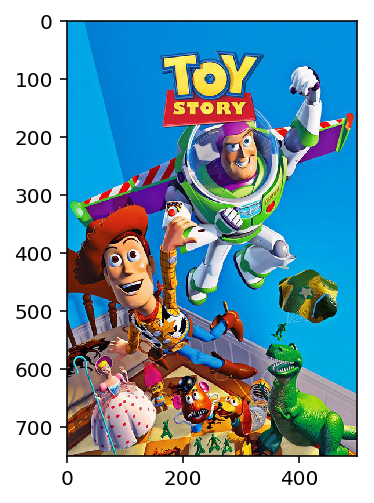

In [79]:
plt.imshow(plt.imread('data/movielens-100k/image/1.jpg'))

## Cora

In [ ]:
from graphsage.model import load_cora

In [ ]:
feat_data, labels, adj_lists = load_cora()
num_nodes, num_feats = feat_data.shape
num_classes = len(np.unique(labels))

num_nodes, num_feats, num_classes

In [ ]:
# Optional: Remove features and use identity matrix instead. 
# Set learning rate to 10 for this.
feat_data = np.eye(num_nodes)
num_feats = num_nodes

num_nodes, num_feats, num_classes

# GCN Layers

In [10]:
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, num_nodes, in_features_func, adj_dict, num_sample=10, activation=F.relu):
        nn.Module.__init__(self)
        self.in_features = in_features
        self.out_features = out_features
        self.in_features_func = in_features_func
        self.adj_dict = adj_dict
        # TODO: Add adj_array (see RelationalGraphConvolution).
        self.num_sample = num_sample
        self.activation = activation
        
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform(self.weight)
        
        
    # TODO: Profile this with lprun and see how much time each step takes up (especially creating the tensors!).
    def aggregate(self, nodes, adj_dict, include_self=False):
        """Return a vector for each node in `nodes` by mean-aggregating feature vectors from its neighborhood (or a sample thereof)."""
        
        # Step 1: For each node, sample some neighbors that we aggregate information from. 
        
        # TODO: Move this up to constructor or even outside of this class.
        #adj_array = np.array([adj_dict[i] for i in range(num_nodes)])
        #sampled_neighbors_per_node = adj_array[nodes]
        #print(sampled_neighbors_per_node)
        sampled_neighbors_per_node = [adj_dict[node] for node in nodes]
        
        # TODO: Replace stuff below by this line, check if it works.
        #sampled_neighbors_per_node = [adj_lists[node].update([node]) if include_self else adj_lists[node] for node in nodes]
        
        # TODO: Check if this improves the network. 
        #       Also, in graphsage, this is done after the sampling step (which doesn't make much sense though).
        # TODO: Check that node is not added to adj_lists permanently.
        if include_self:
            for sampled_neighbors, node in zip(sampled_neighbors_per_node, nodes):
                sampled_neighbors.add(node)
        
        if self.num_sample is not None:
            # TODO: See if local pointers bring speed improvements (see GraphSage code).
            for i in range(len(sampled_neighbors_per_node)):
                if self.num_sample <= len(sampled_neighbors_per_node[i]):
                    sampled_neighbors_per_node[i] = set(random.sample(sampled_neighbors_per_node[i], self.num_sample))
                    
                    
        # Step 2: Find the unique neighbors in all sampled neighbors.
        
        unique_neighbors = list(set.union(*sampled_neighbors_per_node))
        unique_neighbors_to_index = {neighbor: i for i, neighbor in enumerate(unique_neighbors)}
        
        if unique_neighbors:
            
            # Step 3: Get embeddings for these unique neighbors from the underlying layer 
            #         (e.g. another GraphConvolution layer or a fixed feature matrix).
            
            unique_neighbors_tensor = torch.LongTensor(unique_neighbors)
            if self.is_cuda():
                unique_neighbors_tensor = unique_neighbors_tensor.cuda()
            unique_neighbors_embeddings = self.in_features_func(unique_neighbors_tensor)
            

            # Step 4: For each input node, sum the embeddings of its (sampled) neighbors, 
            #         using the embeddings obtained above. The algorithm here uses a masking matrix 
            #         to find the neighbor embeddings for each node and add them in one step. 
            
            # TODO: See if this can be implemented in an easier way (i.e. without mask).
            
            # TODO: Check if this really needs to be a variable.
            # TODO: Maybe store mask in self and fill it with zeros here, so it doesn't have to initalized in each forward pass. 
            mask = Variable(torch.zeros(len(nodes), len(unique_neighbors)), requires_grad=False)
            if self.is_cuda():
                mask = mask.cuda()
            # TODO: Understand and rename variables here.
            column_indices = [unique_neighbors_to_index[neighbor] for sampled_neighbors in sampled_neighbors_per_node for neighbor in sampled_neighbors]
            row_indices = [i for i in range(len(sampled_neighbors_per_node)) for j in range(len(sampled_neighbors_per_node[i]))]
            mask[row_indices, column_indices] = 1

            # TODO: Is this actually the number of neighbors, i.e. does it correspond 
            #       to the normalization constant in RGCN paper?
            num_neighbors = mask.sum(1, keepdim=True)
            mask /= num_neighbors + 1e-10  # prevent zero division
            
            #set_trace()
            
            # TODO: Check what the actual output of this term is.
            return mask.mm(unique_neighbors_embeddings)
        else:
            # TODO: If there are no neighbors, this currently returns a zero vector. Is this correct?
            # TODO: Building this variable and moving it to cuda takes up a lot of time (15 % for Link Prediction),
            #       speed this up somehow.
            zeros = Variable(torch.zeros(len(nodes), self.in_features), requires_grad=False)
            if self.is_cuda():
                zeros = zeros.cuda()
            return zeros

        
    def forward(self, nodes):
        neighborhood_features = self.aggregate(nodes, self.adj_dict, include_self=True)
        
        # TODO: Maybe add features of nodes themselves,
        #       or include nodes themselves in sampling process in aggregate function (as in GraphSAGE,
        #       but collides with RGCN use of aggregate function).
        #node_features = self.in_features_func(torch.LongTensor(nodes))
        
        return self.activation(neighborhood_features.mm(self.weight.t()))
    
    def is_cuda(self):
        return self.weight.is_cuda

In [11]:
class RelationalGraphConvolution(GraphConvolution):
    def __init__(self, in_features, out_features, num_nodes, num_relations, in_features_func, relational_adj_dict, 
                 num_sample=10, activation=F.relu):
        
        super(RelationalGraphConvolution, self).__init__(in_features, out_features, num_nodes, in_features_func, None, num_sample, activation)
        
        # TODO: Maybe create adj_dict from train_triples directly in here.
        self.relational_adj_dict = relational_adj_dict
        self.adj_array = np.array([set(relational_adj_dict[i].keys()) for i in range(num_nodes)], dtype=object)
        
        self.num_relations = num_relations
        
        # TODO: Maybe store the relation weights in a 3D tensor instead of a ParameterList. 
        #       Uses about the same amount of memory. Check if it brings speed improvements.
        self.relation_weights = nn.ParameterList()
        for relation in range(num_relations):
            self.relation_weights.append(nn.Parameter(torch.FloatTensor(out_features, in_features)))
            nn.init.xavier_uniform(self.relation_weights[relation])
        #self.weights_per_relation = nn.Parameter(torch.FloatTensor(num_relations, out_features, in_features))
            
    def forward(self, nodes):
        # TODO: Refactor this by passing nodes as tensor in the first place.
        if type(nodes) == torch.LongTensor or type(nodes) == torch.cuda.LongTensor:
            nodes_tensor = nodes
        else:
            nodes_tensor = torch.LongTensor(nodes)
            if self.is_cuda():
                nodes_tensor = nodes_tensor.cuda()
                
        # Step 1: Get embeddings for all nodes in the mini-batch from the underlying layer.
        #         (e.g. another GraphConvolution layer or a fixed feature matrix).
        input_embeddings = self.in_features_func(nodes_tensor)
        # TODO: Maybe add hyperparameter that determines which fraction of the self-embedding to use, 
        #       and which fraction of the aggregated embedding. See if this has an effect 
        #       or if weights find the best way to combine the two embeddings themselves.
        #       Alternatively, include self-embedding in sampling.
        output_embeddings = input_embeddings.mm(self.weight.t())  # terms for relations will be added to this
                
                
        # Step 2: For each node, sample some neighbors that we aggregate information from. 
        #sampled_neighbors_per_node = [set(self.relational_adj_dict[node]) for node in nodes]
        # TODO: Refactor this to method sample_neighbors(nodes), which uses self.num_sample and self.relational_adj_dict.
        sampled_neighbors_per_node = self.adj_array[nodes]
        if self.num_sample is not None:
            # TODO: Check if local pointers bring speed improvements (see GraphSage code).
            for i in range(len(sampled_neighbors_per_node)):
                if self.num_sample <= len(sampled_neighbors_per_node[i]):
                    # TODO: Check if np.random.choice is faster.
                    sampled_neighbors_per_node[i] = set(random.sample(sampled_neighbors_per_node[i], self.num_sample))
            
        # Step 3: Find the unique neighbors in all sampled neighbors. 
        #         If there are no unique neighbors, return zero embeddings.
        unique_neighbors = list(set.union(*sampled_neighbors_per_node))
        unique_neighbors_to_index = {neighbor: i for i, neighbor in enumerate(unique_neighbors)}
        
        if not unique_neighbors:
            # TODO: Maybe create and store this once, and return it each time here.
            zeros = Variable(torch.zeros(len(nodes), self.out_features), requires_grad=False)
            if self.is_cuda():
                zeros = zeros.cuda()
            print('No unique neighbors, returning zero. Nodes:', nodes)
            return zeros
        
        # Step 3: Get embeddings for these unique neighbors from the underlying layer 
        #         (e.g. another GraphConvolution layer or a fixed feature matrix).
        # TODO: Investigate how much time processing only the unique neighbors actually saves vs the overhead 
        #       done here to reassign unique neighbors to the nodes (for a realistiv batch size!)
        unique_neighbors_tensor = torch.LongTensor(unique_neighbors)
        if self.is_cuda():
            unique_neighbors_tensor = unique_neighbors_tensor.cuda()
        unique_neighbors_embeddings = self.in_features_func(unique_neighbors_tensor)
                
        # Step 4: For each relation, average the embeddings of sampled neighbors, 
        #         using the embeddings obtained above. The algorithm here uses a masking matrix 
        #         to find the neighbor embeddings for each node and add them in one step. 
        mask = Variable(torch.zeros(len(nodes), len(unique_neighbors)), requires_grad=False)
        if self.is_cuda():
            mask = mask.cuda()

        for relation in range(num_relations):
            # TODO: Check which of these three alternatives for masking is quickest:
            #       1) Iterate over all nodes and sampled neighbor, and assign column/row indices only 
            #          if edge has relation (current method).
            #          Potentially iterates very often over the same arrays.
            #       2) Compile one object sampled_neighbors_per_node_per_relation beforehand, 
            #          and do the usual mask-building for each relation in there.
            #       3) Build one mask for each relation and set values in the mask belonging 
            #          to the relation directly.

            column_indices = []
            for node, sampled_neighbors in zip(nodes, sampled_neighbors_per_node):
                for neighbor in sampled_neighbors:
                    #if self.relational_adj_dict[node][neighbor] == relation:
                    if relation in self.relational_adj_dict[node][neighbor]:
                        column_indices.append(unique_neighbors_to_index[neighbor])
                        
            if column_indices:  # if column_indices is empty, there are no sampled neighbors with this relation, so skip it
                row_indices = []
                for i, node in enumerate(nodes):
                    for j, neighbor in enumerate(sampled_neighbors_per_node[i]):
                        #if self.relational_adj_dict[node][neighbor] == relation:
                        if relation in self.relational_adj_dict[node][neighbor]:
                            row_indices.append(i)

                mask[row_indices, column_indices] = 1
                
                # TODO: Here, I divide by the number of neighbors with this relation.
                #       In R-GCN paper, they divide by the number of all neighbors (across relations).
                #       Implement this by summing up these values over all relations.
                #       Also ask Michael, how the results with other normalization constants were.
                num_neighbors_per_node = mask.sum(1, keepdim=True)
                mask /= num_neighbors_per_node + 1e-10  # prevent zero division

                # Non-zero value at (i, j) in mask means that embedding of unique neighbor j contributes 
                # to aggregated embedding for node i (weighted by the value in mask). Formally:
                # aggregated_node_embeddings[i] = \sum_j {mask[i, j] * unique_neighbors_embeddings[j]}
                aggregated_embeddings = mask.mm(unique_neighbors_embeddings)

                # Step 5: Multiply the aggregated feature vectors with the relation-specific weight matrix.
                output_embeddings += aggregated_embeddings.mm(self.relation_weights[relation].t())

            return self.activation(output_embeddings)

In [ ]:
# TODO: New version that uses triples directly. Still uses one relation per edge.
# TODO: Check runtime and performance against old version.
class RelationalGraphConvolution(GraphConvolution):
    def __init__(self, in_features, out_features, num_nodes, num_relations, in_features_func, train_triples, 
                 num_sample=10, activation=F.relu):
        
        super(RelationalGraphConvolution, self).__init__(in_features, out_features, num_nodes, in_features_func, None, num_sample, activation)
        
        # TODO: Maybe create adj_dict from train_triples directly in here.
        #self.relational_adj_dict = relational_adj_dict
        #self.adj_array = np.array([set(relational_adj_dict[i].keys()) for i in range(num_nodes)], dtype=object)
        self.train_triples = train_triples.copy()
        
        self.num_relations = num_relations
        
        # TODO: Maybe store the relation weights in a 3D tensor instead of a ParameterList. 
        #       Uses about the same amount of memory. Check if it brings speed improvements.
        self.relation_weights = nn.ParameterList()
        for relation in range(num_relations):
            self.relation_weights.append(nn.Parameter(torch.FloatTensor(out_features, in_features)))
            nn.init.xavier_uniform(self.relation_weights[relation])
        #self.weights_per_relation = nn.Parameter(torch.FloatTensor(num_relations, out_features, in_features))
            
    def forward(self, nodes):
        # TODO: Refactor this by passing nodes as tensor in the first place.
        if type(nodes) == torch.LongTensor or type(nodes) == torch.cuda.LongTensor:
            nodes_tensor = nodes
        else:
            nodes_tensor = torch.LongTensor(nodes)
            if self.is_cuda():
                nodes_tensor = nodes_tensor.cuda()
                
        # Step 1: Get embeddings for all nodes in the mini-batch from the underlying layer.
        #         (e.g. another GraphConvolution layer or a fixed feature matrix).
        input_embeddings = self.in_features_func(nodes_tensor)
        output_embeddings = input_embeddings.mm(self.weight.t())  # terms for relations will be added to this
                
                
        # Step 2: For each node, sample some neighbors that we aggregate information from. 
        #sampled_neighbors_per_node = [set(self.relational_adj_dict[node]) for node in nodes]
        # TODO: Refactor this to method sample_neighbors(nodes), which uses self.num_sample and self.relational_adj_dict.
#         sampled_neighbors_per_node = self.adj_array[nodes]
#         if self.num_sample is not None:
#             # TODO: Check if local pointers bring speed improvements (see GraphSage code).
#             for i in range(len(sampled_neighbors_per_node)):
#                 if self.num_sample <= len(sampled_neighbors_per_node[i]):
#                     # TODO: Check if np.random.choice is faster.
#                     sampled_neighbors_per_node[i] = set(random.sample(sampled_neighbors_per_node[i], self.num_sample))
        # TODO: Check how long this takes. Maybe create triples_per_node for all nodes in constructor.
        sampled_triples_per_node = [train_triples[train_triples[:, 0] == node] for node in nodes]
        if self.num_sample is not None:
            for i in range(len(sampled_triples_per_node)):
                if self.num_sample <= len(sampled_triples_per_node[i]):
                    sampled_triples_per_node[i] = sampled_triples_per_node[i][np.random.choice(len(sampled_triples_per_node[i], size=self.num_sample))]

            
        # Step 3: Find the unique neighbors in all sampled neighbors. 
        #         If there are no unique neighbors, return zero embeddings.
        unique_neighbors = np.unique(np.hstack([sampled_triples[:, 1] for sampled_triples in sampled_triples_per_neighbor]))#list(set.union(*sampled_neighbors_per_node))
        unique_neighbors_to_index = {neighbor: i for i, neighbor in enumerate(unique_neighbors)}
        
        # TODO: Check if this works with array.
        if not unique_neighbors:
            # TODO: Maybe create and store this once, and return it each time here.
            zeros = Variable(torch.zeros(len(nodes), self.out_features), requires_grad=False)
            if self.is_cuda():
                zeros = zeros.cuda()
            print('No unique neighbors, returning zero. Nodes:', nodes)
            return zeros
        
        # Step 3: Get embeddings for these unique neighbors from the underlying layer 
        #         (e.g. another GraphConvolution layer or a fixed feature matrix).
        # TODO: Investigate how much time processing only the unique neighbors actually saves vs the overhead 
        #       done here to reassign unique neighbors to the nodes (for a realistiv batch size!)
        unique_neighbors_tensor = torch.LongTensor(unique_neighbors)
        if self.is_cuda():
            unique_neighbors_tensor = unique_neighbors_tensor.cuda()
        unique_neighbors_embeddings = self.in_features_func(unique_neighbors_tensor)
                
        # Step 4: For each relation, average the embeddings of sampled neighbors, 
        #         using the embeddings obtained above. The algorithm here uses a masking matrix 
        #         to find the neighbor embeddings for each node and add them in one step. 
        mask = Variable(torch.zeros(len(nodes), len(unique_neighbors)), requires_grad=False)
        if self.is_cuda():
            mask = mask.cuda()

        for relation in range(num_relations):
            # TODO: Check which of these three alternatives for masking is quickest:
            #       1) Iterate over all nodes and sampled neighbor, and assign column/row indices only 
            #          if edge has relation (current method).
            #          Potentially iterates very often over the same arrays.
            #       2) Compile one object sampled_neighbors_per_node_per_relation beforehand, 
            #          and do the usual mask-building for each relation in there.
            #       3) Build one mask for each relation and set values in the mask belonging 
            #          to the relation directly.

            column_indices = []
            for node, sampled_neighbors in zip(nodes, sampled_neighbors_per_node):
                for neighbor in sampled_neighbors:
                    if relation in self.relational_adj_dict[node][neighbor]:
                        column_indices.append(unique_neighbors_to_index[neighbor])
                        
            if column_indices:  # if column_indices is empty, there are no sampled neighbors with this relation, so skip it
                row_indices = []
                for i, node in enumerate(nodes):
                    for j, neighbor in enumerate(sampled_neighbors_per_node[i]):
                        if relation in self.relational_adj_dict[node][neighbor]:
                            row_indices.append(i)

                mask[row_indices, column_indices] = 1
                
                # TODO: Here, I divide by the number of neighbors with this relation.
                #       In R-GCN paper, they divide by the number of all neighbors (across relations).
                #       Implement this by summing up these values over all relations.
                #       Also ask Michael, how the results with other normalization constants were.
                num_neighbors_per_node = mask.sum(1, keepdim=True)
                mask /= num_neighbors_per_node + 1e-10  # prevent zero division

                # Non-zero value at (i, j) in mask means that embedding of unique neighbor j contributes 
                # to aggregated embedding for node i (weighted by the value in mask). Formally:
                # aggregated_node_embeddings[i] = \sum_j {mask[i, j] * unique_neighbors_embeddings[j]}
                aggregated_embeddings = mask.mm(unique_neighbors_embeddings)

                # Step 5: Multiply the aggregated feature vectors with the relation-specific weight matrix.
                output_embeddings += aggregated_embeddings.mm(self.relation_weights[relation].t())

            return self.activation(output_embeddings)

# Supervised Classification (without relations and features)

In [16]:
class SupervisedGCN(nn.Module):

    def __init__(self, num_classes, feat_data, adj_lists):
        nn.Module.__init__(self)
        
        num_nodes, num_features = feat_data.shape
        
        features = nn.Embedding(num_nodes, num_features)
        features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
        
        self.graph_conv1 = GraphConvolution(num_features, 128, features, adj_lists, activation=F.relu)
        self.graph_conv2 = GraphConvolution(128, 128, self.graph_conv1, adj_lists, activation=F.relu)
        
        # TODO: Converges faster without bias. See if this holds for real data.
        self.dense = nn.Linear(128, num_classes, bias=False)
        nn.init.xavier_uniform(self.dense.weight)

    def forward(self, nodes):
        node_embeddings = self.graph_conv2(nodes)  # implicitly calls underlying conv layers
        scores = self.dense(node_embeddings)
        return scores

In [17]:
# Run algorithm.
np.random.seed(1)
random.seed(1)

use_cuda = True

net = SupervisedGCN(num_classes, feat_data, adj_dict)
if use_cuda and torch.cuda.is_available():
    print('Moving network to GPU.')
    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:500]
val = rand_indices[500:1000]
train = list(rand_indices[1000:])

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.01)

times = []
for batch in range(100):
    #batch_nodes = Variable(torch.LongTensor(train[:256]), requires_grad=False)
    batch_nodes = train[:256]
    random.shuffle(train)
    
    start_time = time.time()
    
    optimizer.zero_grad()
    
    output = net(batch_nodes)
    target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
    if use_cuda and torch.cuda.is_available():
        target = target.cuda()
    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    
    end_time = time.time()
    times.append(end_time-start_time)
    print(batch, loss.data[0])
    
    if batch % 10 == 0:
        val_output = net(val) 
        print("Validation Accuracy:", accuracy_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1)))
        print("Validation F1:", f1_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1), average="micro"))
        print("Average batch time:", np.mean(times))

Moving network to GPU.
0 0.692896485329
Validation Accuracy: 0.634
Validation F1: 0.634
Average batch time: 0.1904129981994629
1 0.667886972427
2 0.612422704697
3 0.529688358307
4 0.42939171195
5 0.319299668074
6 0.250481367111
7 0.250862538815
8 0.194756746292
9 0.183181121945
10 0.152682065964
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.06710889122702858
11 0.123559959233
12 0.0772185176611
13 0.0510042309761
14 0.0365696884692
15 0.0187319889665
16 0.0101769454777
17 0.00538808479905
18 0.00236057955772
19 0.000963839702308
20 0.000447682105005
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.06511790411812919
21 0.00017000362277
22 8.49878415465e-05
23 3.43294814229e-05
24 1.98967754841e-05
25 1.02631747723e-05
26 4.99188899994e-06
27 2.59838998318e-06
28 1.47707760334e-06
29 2.25566327572e-06
30 1.52364373207e-06
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.06462906252953314
31 4.22820448875e-07
32 1.02631747723e-06
33 6.

In [174]:
# Alternative version with epochs and progressbar.
# TODO: Update CUDA support.

from tqdm import tqdm

# Run algorithm.
np.random.seed(1)
random.seed(1)

net = SupervisedGCN(num_classes, feat_data, adj_lists)
#    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:500]
val = rand_indices[500:1000]
train = list(rand_indices[1000:])

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.01)

num_epochs = 10
batch_size = 256

for epoch in range(1, num_epochs+1):
    
    
    #tqdm.write('Epoch {}/{}:'.format(epoch, num_epochs-1))

    random.shuffle(train)
    num_batches = int(len(train) / batch_size)
    
    with tqdm(total=num_batches, desc='Epoch {}/{}'.format(epoch, num_epochs), ncols=110) as pbar:

        for batch in range(num_batches):

            #print('\tBatch {}/{}:'.format(batch, num_batches-1), end=' ')

            from_node = batch * batch_size
            to_node = min((batch + 1) * batch_size, len(train))
            batch_nodes = train[from_node:to_node]

            optimizer.zero_grad()

            output = net(batch_nodes)
            target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()

            pbar.set_postfix(loss=loss.data[0])
            #print(loss.data[0])
            
            pbar.update()

        val_output = net(val) 
        val_acc = accuracy_score(labels[val], val_output.data.numpy().argmax(axis=1))
        val_f1 = f1_score(labels[val], val_output.data.numpy().argmax(axis=1), average="micro")
        pbar.set_postfix(loss=loss.data[0], val_acc=val_acc, val_f1=val_f1)


Epoch 10/10: 100%|██████████████████████████| 6/6 [00:01<00:00,  6.64it/s, loss=1.61e-13, val_acc=1, val_f1=1]


# Supervised Classification with relations

In [16]:
class SupervisedRGCN(nn.Module):

    def __init__(self, num_classes, feat_data, adj_lists_per_relation):
        nn.Module.__init__(self)
        
        num_nodes, num_features = feat_data.shape
        features = nn.Embedding(num_nodes, num_features)
        features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
        
        self.graph_conv1 = RelationalGraphConvolution(num_features, 128, features, adj_lists_per_relation)
        self.graph_conv2 = RelationalGraphConvolution(128, 128, self.graph_conv1, adj_lists_per_relation)
        
        # TODO: Converges faster without bias. See if this holds for real data.
        self.dense = nn.Linear(128, num_classes, bias=False)
        nn.init.xavier_uniform(self.dense.weight)

    def forward(self, nodes):
        node_embeddings = self.graph_conv2(nodes)  # implicitly calls underlying conv layers
        #print(node_embeddings.sum())
        scores = self.dense(node_embeddings)  # softmax is applied by CrossEntropyLoss
        return scores


In [19]:
# Run algorithm.
np.random.seed(1)
random.seed(1)

use_cuda = True

net = SupervisedRGCN(num_classes, feat_data, adj_lists_per_relation)
if use_cuda and torch.cuda.is_available():
    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:500]
val = rand_indices[500:1000]
train = list(rand_indices[1000:])
print('Training on', len(train), 'nodes')

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.01)

times = []
for batch in range(100):
    #batch_nodes = Variable(torch.LongTensor(train[:256]), requires_grad=False)
    
    random.shuffle(train)
    batch_nodes = train[:256]
    
    start_time = time.time()
    
    optimizer.zero_grad()
    
    output = net(batch_nodes)
    target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
    if use_cuda and torch.cuda.is_available():
        target = target.cuda()
    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    
    end_time = time.time()
    times.append(end_time-start_time)
    print(batch, loss.data[0])
    
    if batch % 10 == 0:
        val_output = net(val) 
        print("Validation Accuracy:", accuracy_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1)))
        print("Validation F1:", f1_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1), average="micro"))
        print("Average batch time:", np.mean(times))

Training on 1625 nodes
0 0.690665960312
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.19429492950439453
1 0.56970000267
2 0.422767162323
3 0.333146989346
4 0.244888827205
5 0.187118723989
6 0.116868980229
7 0.0616429522634
8 0.031066134572
9 0.0174713600427
10 0.00768253672868
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.1721870248967951
11 0.00573282269761
12 0.00264684483409
13 0.00133715290576
14 0.00102490792051
15 0.00063599832356
16 0.000389914028347
17 0.000162918586284
18 0.000254969578236
19 0.000120875425637
20 8.7134540081e-06
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.16201589221046084
21 8.99191945791e-06
22 1.94106251001e-05
23 1.6987323761e-06
24 1.47707760334e-06
25 3.20374965668e-07
26 4.7042965889e-05
27 1.33737921715e-05
28 8.17980617285e-06
29 8.38190317154e-08
30 1.30385160446e-07
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.1524044159919985
31 2.64495611191e-07
32 1.63912773132e-0

# Link Prediction

## Models

In [12]:
class DistMultScorer(nn.Module):
    
    def __init__(self, embedding_size, num_relations):
        nn.Module.__init__(self)
        self.relation_embedding = nn.Embedding(num_relations, embedding_size)
        nn.init.xavier_normal(self.relation_embedding.weight)
        
    def forward(self, subject_embeddings, object_embeddings, relations):
        # TODO: Give relations as tensor in the first place.
        relations_tensor = Variable(torch.LongTensor(relations), requires_grad=False)
        if self.relation_embedding.weight.is_cuda:
            relations_tensor = relations_tensor.cuda()
            
        relation_embeddings = self.relation_embedding(relations_tensor)
        scores = (subject_embeddings * relation_embeddings * object_embeddings).sum(1, keepdim=True)
        
        return scores

In [13]:
# Pure DistMult for baseline.
class DistMult(nn.Module):
    
    def __init__(self, embedding_size, num_nodes, num_relations, input_dropout_rate=0):
        super(DistMult, self).__init__()
        self.entity_embedding = nn.Embedding(num_nodes, embedding_size)
        self.scorer = DistMultScorer(embedding_size, num_relations)
        self.input_dropout = torch.nn.Dropout(input_dropout_rate)
        nn.init.xavier_normal(self.entity_embedding.weight)
        
        
    def forward(self, triples):
        # TODO: Give triples as variables here in the first place.
        subject_tensor = Variable(torch.LongTensor(triples[:, 0]), requires_grad=False)
        if self.entity_embedding.weight.is_cuda:
            subject_tensor = subject_tensor.cuda()
            
        subject_embeddings = self.entity_embedding(subject_tensor)
        subject_embeddings = self.input_dropout(subject_embeddings)
            
        object_tensor = Variable(torch.LongTensor(triples[:, 1]), requires_grad=False)
        if self.entity_embedding.weight.is_cuda:
            object_tensor = object_tensor.cuda()
            
        object_embeddings = self.entity_embedding(object_tensor)
        object_embeddings = self.input_dropout(object_embeddings)
            
        return self.scorer(subject_embeddings, object_embeddings, triples[:, 2])
    
    # TODO: Dirty workaround for ranking evaluation. Handle triples/entities as tensors everywhere, than this (net.get_embeddings) can be substituted by net.entitiy_embedding
    def get_embeddings(self, entities):
        entities_tensor = Variable(torch.LongTensor(entities), requires_grad=False)
        if self.entity_embedding.weight.is_cuda:
            entities_tensor = entities_tensor.cuda()
            
        return self.entity_embedding(entities_tensor)

In [14]:
class UnsupervisedRGCN(nn.Module):

    # TODO: Add Dropout.
    # TODO: Rename feat_data to node_features. 
    def __init__(self, num_nodes, num_relations, relational_adj_dict, feat_data=None, embedding_size=128, num_sample=10):
        nn.Module.__init__(self)
        
        if feat_data is not None:
            # Use a dense embedding matrix initialized from feat_data.
            # TODO: Maybe give feat_data as tensor in the first place.
            num_features = feat_data.shape[1]
            features_embedding = nn.Embedding(num_nodes, num_features)
            features_embedding.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
            print('Initialized from feat_data')
        else:
            # Use a one-hot embedding that is generated on the fly during training.
            # Saves 0.8 GB GPU memory on FB15k-237 without increasing the runtime 
            # (vs using a feat_data matrix with one-hot embeddings).
            num_features = num_nodes
            features_embedding = OneHotEmbedding(num_nodes, cuda=True)
            print('Initialized with OneHotEmbedding')
        
        #set_trace()
        # TODO: Maybe move num_relations to third parameter.
        self.graph_conv1 = RelationalGraphConvolution(num_features, embedding_size, num_nodes, num_relations, 
                                                      features_embedding, relational_adj_dict, 
                                                      num_sample)
        self.graph_conv2 = RelationalGraphConvolution(embedding_size, embedding_size, num_nodes, num_relations, 
                                                      self.graph_conv1, relational_adj_dict, 
                                                      num_sample)
        
        self.dist_mult = DistMultScorer(embedding_size, num_relations)
        
    def forward(self, triples):
        # TODO: This computes lots of duplicates if nodes appear in multiple triples or as subject and object.
        #       See if this can be improved by finding the unique nodes, running graph_conv2 on them once,
        #       and then merging this back. Could also be applied in GraphConvolution (in addition to here, 
        #       because GraphConvolution cannot consider duplicates in subject and object).
        #unique_nodes = set.union(set(triples[:, 0]), set(triples[:, 1]))
        #unique_nodes_to_index = {node: i for i, node in enumerate(unique_nodes)}
        
        #unique_nodes_features = self.graph_conv2(unique_nodes)
        #print(unique_nodes_features)
        
        from_node_embeddings = self.graph_conv2(triples[:, 0])  # implicitly calls underlying conv layers
        to_node_embeddings = self.graph_conv2(triples[:, 1])  # implicitly calls underlying conv layers
        
        scores = self.dist_mult(from_node_embeddings, to_node_embeddings, triples[:, 2])
        return scores

In [15]:
class OneHotEmbedding(nn.Module):
    
    def __init__(self, num_embeddings, cuda=False):
        super(OneHotEmbedding, self).__init__()
        self.num_embeddings = num_embeddings
        self.row = torch.zeros(num_embeddings)
        # TODO: Figure out a way to move row to cuda as soon as cuda is called on the net.
        if cuda:
            self.row = self.row.cuda()
        
    def forward(self, indices):
        self.row.zero_()
        embeddings = self.row.repeat(len(indices), 1)
        embeddings[range(len(indices)), indices] = 1
        return Variable(embeddings, requires_grad=False)

## Utils for training and evaluation

In [16]:
def sample_negatives(triples, num_nodes, num_negatives=1):
    """Return a copy of triples where either the subject or the object in each triple is replaced with a random entity."""
    corrupted_triples = []
    for i in range(num_negatives):
        for s, o, r in triples:
            if np.random.rand() < 0.5:
                corrupted_triples.append((np.random.randint(num_nodes), o, r))
            else:
                corrupted_triples.append((s, np.random.randint(num_nodes), r))
    return np.asarray(corrupted_triples)

class SimplifiedMarginRankingLoss(nn.MarginRankingLoss):
    """Same as torch.nn.MarginRankingLoss, but input1 is always higher than input2."""
    
    def __call__(self, input1, input2):
        target = Variable(torch.ones(input1.shape), requires_grad=False)
        if input1.is_cuda:
            target = target.cuda()
        return super(SimplifiedMarginRankingLoss, self).__call__(input1, input2, target)

In [17]:
class RankingEvaluation(object):
    
    def __init__(self, triples, num_nodes, filtered=False, show_progress=False):
        self.triples = triples
        self.num_nodes = num_nodes
        self.filtered = filtered
        
        
        if self.filtered:
            self.true_triples_subject_corrupted_per_triple = []
            self.true_triples_object_corrupted_per_triple = []
            
            for s, o, r in tqdm_notebook(self.triples) if show_progress else self.triples:
                # TODO: Rename this.
                self.true_triples_subject_corrupted_per_triple.append(
                    all_triples_arr[np.logical_and(all_triples_arr[:, 1] == o, all_triples_arr[:, 2] == r)][:, 0])
                self.true_triples_object_corrupted_per_triple.append(
                    all_triples_arr[np.logical_and(all_triples_arr[:, 0] == s, all_triples_arr[:, 2] == r)][:, 1])
            
                #print(triple, len(self.true_triples_subject_corrupted_per_triple[-1]), len(self.true_triples_object_corrupted_per_triple[-1]))
                
            print('Subject-corrupted triples: Found on average', np.mean([len(arr) for arr in self.true_triples_subject_corrupted_per_triple]), 'triples that were actually true')
            print('Object-corrupted triples: Found on average', np.mean([len(arr) for arr in self.true_triples_object_corrupted_per_triple]), 'triples that were actually true')
                
                
    def _get_rank(self, scoring_model, subject_embeddings, object_embeddings, relations, n, true_triples=None):
        scores_gpu = scoring_model(subject_embeddings, object_embeddings, relations)
        scores = scores_gpu.cpu().data.numpy()
        del scores_gpu  # TODO: Check if this improves GPU memory.
        #scores = utils.predict(scoring_model, [subject_embeddings, object_embeddings, relations], batch_size=16, move_to_cuda=True, move_to_cpu=True)
        score_true_triple = scores[n]
        
        # TODO: Maybe do not delete the scores, but set them to 0, like in ConvE code. 
        #       Especially in combination with the pytorch speedup of ranking, see below.
        if self.filtered:
            scores_corrupted_triples = np.delete(scores, true_triples)
            #print('Removed', len(scores) - len(scores_corrupted_triples), 'triples')
        else:
            scores_corrupted_triples = np.delete(scores, [n])
            
        # TODO: This takes up 53 % of the time in this function. Speed it up by doing this directly in pytorch.
        #       See ConvE code (evaluation.py):
        #       max_values, argsort1 = torch.sort(pred1, 1, descending=True)
        #       argsort1 = argsort1.cpu().numpy()
        #       rank1 = np.where(argsort1[i]==e2[i, 0])[0][0]
        rank = sp.stats.rankdata(-np.hstack([score_true_triple, scores_corrupted_triples]), 'ordinal')[0]  # apply negative so highest score is 
        
        #rank_unfiltered = sp.stats.rankdata(-scores, 'ordinal')[n]
        #print(rank, rank_unfiltered, '--> changed', rank_unfiltered-rank, 'ranks')
        
        return rank
    
    
    def __call__(self, embedding_model, scoring_model, verbose=False, show_progress=False):
        
        # TODO: Run prediction batched (e.g. by using utils.predict). 
        #all_node_embeddings = utils.predict(embedding_model, np.arange(self.num_nodes), batch_size=16, move_to_cpu=True)
        all_node_embeddings = embedding_model(np.arange(self.num_nodes))
        ranks = []

        for i, triple in enumerate(tqdm_notebook(self.triples)) if show_progress else enumerate(self.triples):
            #print(triple, ':', end=' ')

            repeated_subject_embedding = all_node_embeddings[triple[0]].expand(self.num_nodes, -1)
            repeated_object_embedding = all_node_embeddings[triple[1]].expand(self.num_nodes, -1)
            repeated_relation = np.repeat(triple[2], self.num_nodes)

            # TODO: Refactor this.
            rank_subject_corrupted = self._get_rank(scoring_model, all_node_embeddings, repeated_object_embedding, repeated_relation, triple[0], self.true_triples_subject_corrupted_per_triple[i] if self.filtered else None)
            ranks.append(rank_subject_corrupted)
            
            rank_object_corrupted = self._get_rank(scoring_model, repeated_subject_embedding, all_node_embeddings, repeated_relation, triple[1], self.true_triples_object_corrupted_per_triple[i] if self.filtered else None)
            ranks.append(rank_object_corrupted)
            
            # TODO: Check if these are more or less the same.
            if verbose: print(rank_subject_corrupted, rank_object_corrupted)
            
        ranks = np.asarray(ranks)
        
        def hits_at(n):
            return np.sum(ranks <= n) / len(ranks)
        
        del all_node_embeddings

        return np.mean(ranks), np.mean(1 / ranks), hits_at(1), hits_at(3), hits_at(10)

## Training

In [18]:
# Set up dataset splits and ranking evaluation. 
#train, val, test = utils.train_val_test_split(train_triples_arr, val_size=5000, test_size=5000, random_state=0)

# TODO: Either rename train_triples_arr into train above, or rename the variables here.
# For FB15k-237 (split is already provided in the original dataset).
train = train_triples_arr
val = val_triples_arr
test = test_triples_arr

filtered = True
# TODO: Check if using a larger subset of train makes the ranking results more similar to the ones for val.
train_ranker = RankingEvaluation(train[:5000], num_nodes, filtered=filtered, show_progress=True)
val_ranker = RankingEvaluation(val, num_nodes, filtered=filtered, show_progress=True)

HBox(children=(IntProgress(value=0, max=5000), HTML(value=u'')))


Subject-corrupted triples: Found on average 309.3452 triples that were actually true
Object-corrupted triples: Found on average 34.7736 triples that were actually true


HBox(children=(IntProgress(value=0, max=17535), HTML(value=u'')))


Subject-corrupted triples: Found on average 440.97005988023955 triples that were actually true
Object-corrupted triples: Found on average 37.21083547191331 triples that were actually true


In [19]:
# Option 1: R-GCN
net = UnsupervisedRGCN(num_nodes, num_relations, relational_adj_dict, embedding_size=200, feat_data=None)#256, 10)
embedding_func, scoring_func = net.graph_conv2, net.dist_mult  # required for ranking
loss_function = SimplifiedMarginRankingLoss(1)
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
batch_size = 32

Initialized with OneHotEmbedding


In [60]:
# Option 2: DistMult
# TODO: In original DistMult paper, embeddings are normalized to unit length after each training step. Improves model empricially.
net = DistMult(200, num_nodes, num_relations, 0.4)
embedding_func, scoring_func = net.get_embeddings, net.scorer  # required for ranking
loss_function = SimplifiedMarginRankingLoss(1)
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.001)
batch_size = 32

In [ ]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
    net.cuda()
    print('Moved network to GPU')
    
history = utils.History()

Moved network to GPU


In [ ]:
# Training loop. Run this again to continue training on the same network. 

# TODO: Results seem to be very random (MRR after 1st epoch fluctuates between 0.2 and 0.3)
#       See if this converges after more epochs. Try to make it more stable.

# TODO: Use seed 0 here.
# TODO: Maybe set pytorch seed here.
np.random.seed(1)
random.seed(1)

# TODO: Implement training via classification of correct/corrupted triples.

num_epochs = 100

for epoch in range(num_epochs):

    print('Epoch {}/{}'.format(epoch+1, num_epochs))

    # This is for classification training.
    # num_negatives = 2
    # train_and_negatives = np.hstack([train, sample_negatives(train, num_nodes, num_negatives)])
    # print(train_and_negatives.shape)
    # y = Variable(torch.zeros(len(train_and_negatives), 1), requires_grad=False)
    # y[:len(train), 0] = 1
    # if use_cuda and torch.cuda.is_available():
    #     y = y.cuda()
    # TODO: Wrap train_and_negatives and y in list of tuples or make split_into_batches accept multiple arrays.
    # batches = tqdm_notebook(split_into_batches(train_and_negatives, batch_size, shuffle=True))

    # TODO: Use tensor for batch_triples and wrap everything here in pytorch DataSet/DataLoader.
    batches = utils.split_into_batches(train, batch_size=batch_size, shuffle=True)#[:3]
    batches = tqdm_notebook(batches)
    batches_history = utils.History()

    for batch, batch_triples in enumerate(batches):

        optimizer.zero_grad()
        output = net(batch_triples)
        output_negative = net(sample_negatives(batch_triples, num_nodes))

        loss = loss_function(output, output_negative)
        # loss = loss_function(output, y)
        loss.backward()
        optimizer.step()

        # TODO: Especially getting the loss takes quite some time (as much as a single prediction for dist mult), maybe replace it by a running metric directly in torch.
        batches_history.log_metric('loss', loss.data[0])
        batches_history.log_metric('acc', (output > output_negative).float().mean().data[0])
        batches_history.log_metric('mean_diff', (output - output_negative).mean().data[0])
        batches_history.log_metric('median_diff', (output - output_negative).median().data[0])

        if batch % 10 == 0:
            batches.set_postfix(batches_history.latest())

        # TODO: Check if this improves memory usage.
        del output, output_negative, loss


    net.eval()
    # TODO: Maybe sample over more/all nodes when testing. This should give better results. Make sure that the normalization is correct in this case! Also, need to implement num_sample as parameter to forward method then.
    # TODO: Set variables to volatile=True when evaluating on the validation set to save GPU memory.
    # TODO: Somehow, predict still takes up way to much gpu memory (around 5GB for val on fb15k-237; even though this is less than running the net directly on val, because this gives an OOM error). First, check that this is not just cached by doing torch.cuda.empty_cache() after every step. Then, check out that the variables are properly deleted.
    val_output = utils.predict(net, val, batch_size=16, move_to_cpu=True)
    val_output_negative = utils.predict(net, sample_negatives(val, num_nodes), batch_size=16, move_to_cpu=True)
    net.train()
    #net.eval()
    #val_output = net(val)
    #val_output_negative = net(sample_negatives(val, num_nodes))
    #net.train()

#     # TODO: Implement these metrics in a batched fashion, then increase size of validation set.
    history.log_metric('loss', batches_history.mean('loss'), 
                       loss_function(val_output, val_output_negative).data[0], 'Loss', print_=True)
    history.log_metric('acc', batches_history.mean('acc'), 
                       (val_output > val_output_negative).float().mean().data[0], 'Accuracy', print_=True)
    history.log_metric('mean_diff', batches_history.mean('mean_diff'), 
                       (val_output - val_output_negative).mean().data[0], 'Mean Difference', print_=True)
    history.log_metric('median_diff', batches_history.mean('median_diff'), 
                       (val_output - val_output_negative).median().data[0], 'Median Difference', print_=True)

    del val_output, val_output_negative

    print('Running rank evaluation for train in {} setting...'.format('filtered' if train_ranker.filtered else 'raw'))
    mean_rank, mean_rec_rank, hits_1, hits_3, hits_10 = train_ranker(embedding_func, scoring_func)
    print('Running rank evaluation for val in {} setting...'.format('filtered' if val_ranker.filtered else 'raw'))
    val_mean_rank, val_mean_rec_rank, val_hits_1, val_hits_3, val_hits_10 = val_ranker(embedding_func, scoring_func)
    history.log_metric('mean_rank', mean_rank, val_mean_rank, 'Mean Rank', print_=True)
    history.log_metric('mean_rec_rank', mean_rec_rank, val_mean_rec_rank, 'Mean Rec Rank', print_=True)
    history.log_metric('hits_1', hits_1, val_hits_1, 'Hits@1', print_=True)
    history.log_metric('hits_3', hits_3, val_hits_3, 'Hits@3', print_=True)
    history.log_metric('hits_10', hits_10, val_hits_10, 'Hits@10', print_=True)

    print('-'*80)
    print()


Epoch 1/100


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.643466272927
Val Loss:   0.532911598682

Accuracy:       0.65466463924
Val Accuracy:   0.65309381485

Mean Difference:       0.939377012972
Val Mean Difference:   1.38626670837

Median Difference:       0.419444922007
Val Median Difference:   0.68320196867

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       1395.0101
Val Mean Rank:   1519.16447106

Mean Rec Rank:       0.250434597835
Val Mean Rec Rank:   0.308377005381

Hits@1:       0.2279
Val Hits@1:   0.285514684916

Hits@3:       0.252
Val Hits@3:   0.310436270317

Hits@10:       0.2896
Val Hits@10:   0.350613059595

--------------------------------------------------------------------------------

Epoch 2/100


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))


Loss:       0.417110737229
Val Loss:   0.441215634346

Accuracy:       0.72370451831
Val Accuracy:   0.682805836201

Mean Difference:       2.1168095995
Val Mean Difference:   2.26128172874

Median Difference:       1.38864762366
Val Median Difference:   1.38592028618

Running rank evaluation for train in filtered setting...
Running rank evaluation for val in filtered setting...
Mean Rank:       909.3122
Val Mean Rank:   974.238437411

Mean Rec Rank:       0.255974479969
Val Mean Rec Rank:   0.312223870033

Hits@1:       0.2274
Val Hits@1:   0.28252067294

Hits@3:       0.2594
Val Hits@3:   0.316424294269

Hits@10:       0.3047
Val Hits@10:   0.364898773881

--------------------------------------------------------------------------------

Epoch 3/100


HBox(children=(IntProgress(value=0, max=8504), HTML(value=u'')))

In [ ]:
# TODO: Why are ranking results on validation set better than on train set for R-GCN?
# TODO: Why is mean rank so much worse than in papers (~600 vs 250) for R-GCN?
# TODO: Why is hits@1 better, but hits@10 worse for my R-GCN compared to the original implementation as well as to other papers?
# TODO: Why do results vary so much from run to run?

In [48]:
%lprun -f RelationalGraphConvolution.forward net(batch_triples)

In [ ]:
# Changes vs 9: New ranking algorithm based on numpy indexing, filtered ranking, ranking on complete val set

## Evaluation plots

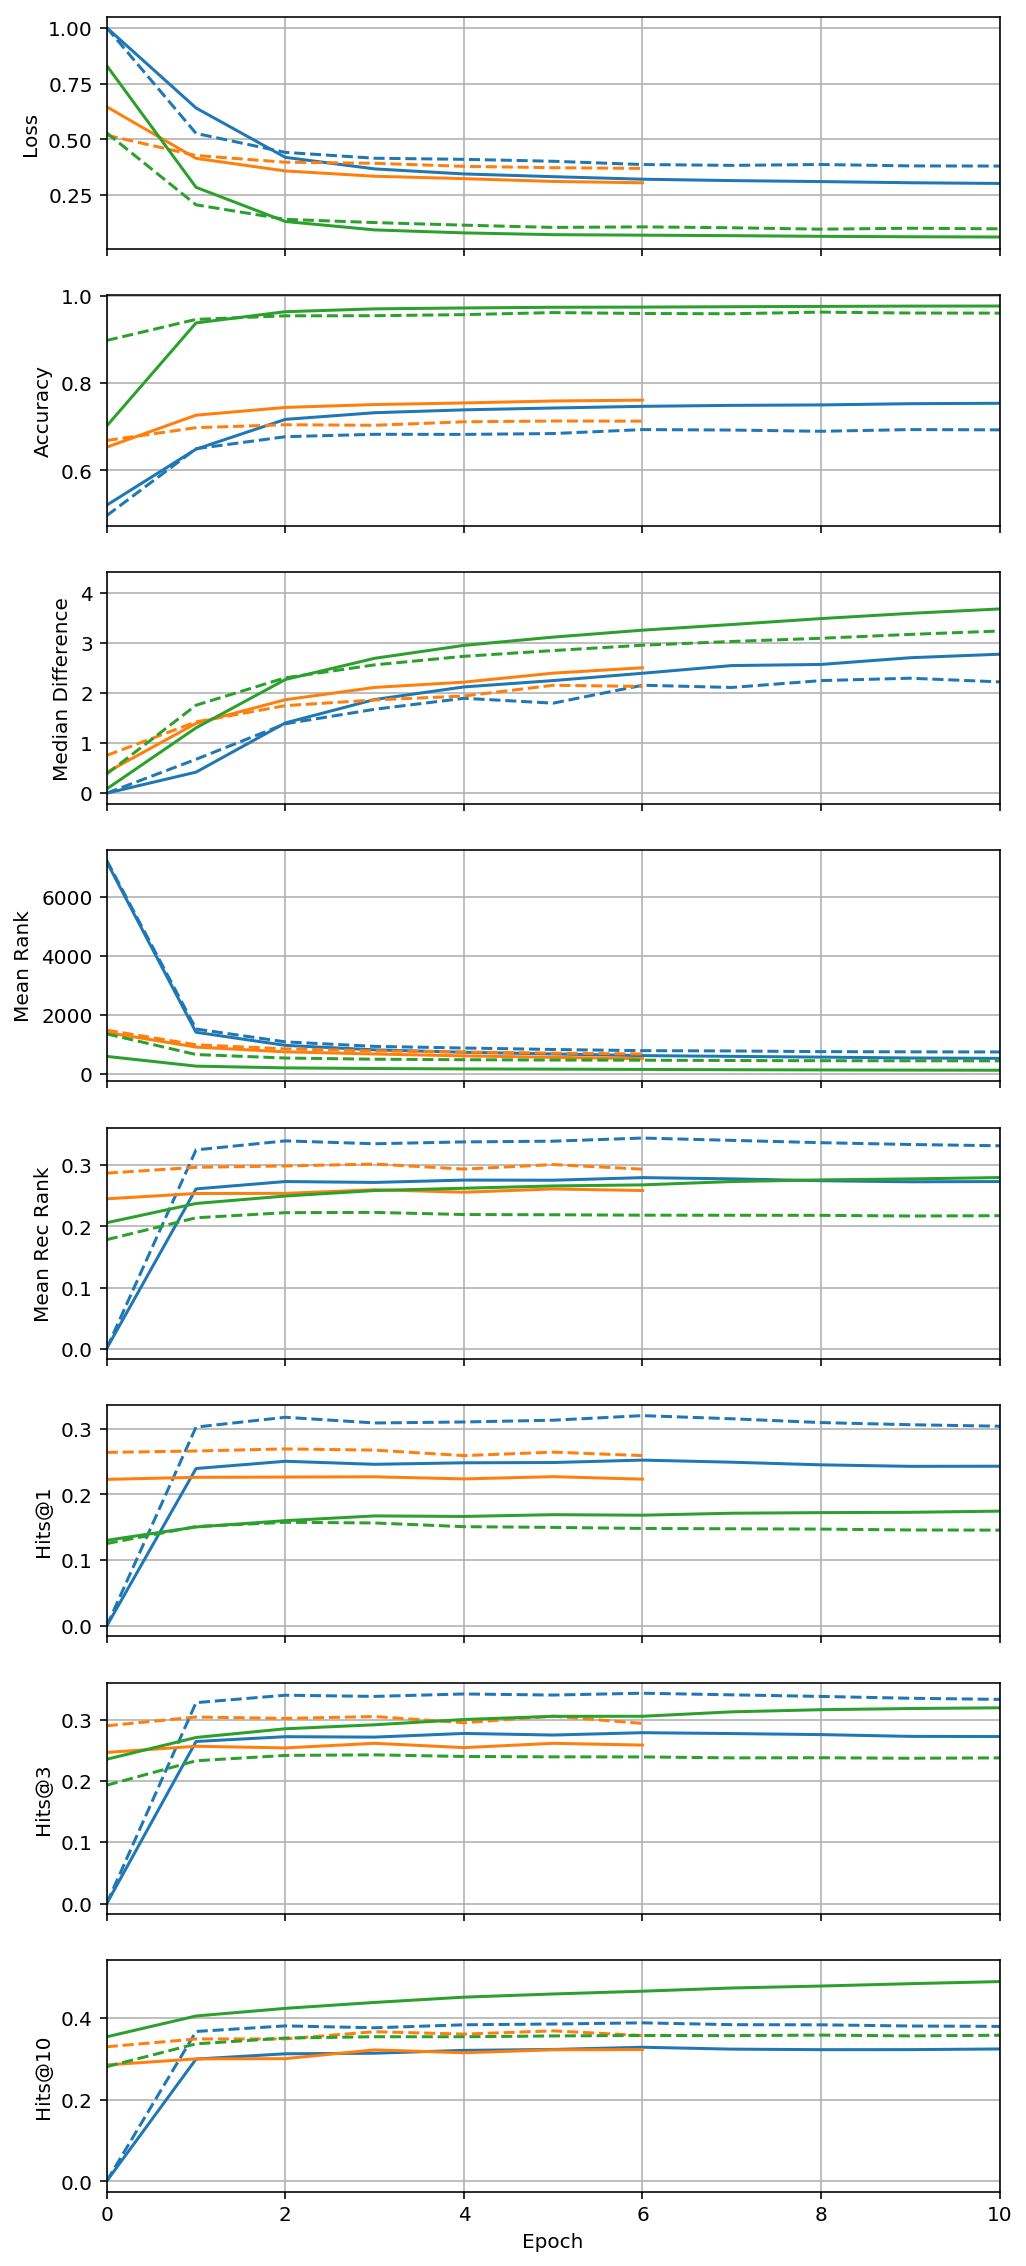

In [26]:
to_plot = ['loss', 'acc', 'median_diff', 'mean_rank', 'mean_rec_rank', 'hits_1', 'hits_3', 'hits_10']
figsize = (8, 20)

# TODO: Make fig legend for compare histories.
history.plot(*to_plot, figsize=figsize, compare=['logs/10_rgcn_new-ranking-algorithm_filtered-ranking-on-complete-val-set.tsv', 'logs/11_dist-mult.tsv'], xlim=(0, 10))

In [35]:
history

History([(u'loss',
          [0.9999992251396179,
           0.640682081500049,
           0.419742116938509,
           0.3679905759279291,
           0.34548194087106077,
           0.3332863565059493,
           0.3218788830537142,
           0.3156644727636973,
           0.31126186034711373,
           0.30604466109695166,
           0.30293388417808065,
           0.3000387746620808,
           0.2970968564027817,
           0.2955318395287562,
           0.2915853128872763,
           0.2906116736607726,
           0.2884252286861762,
           0.2887706640053817]),
         (u'val_loss',
          [1.000000238418579,
           0.5269286036491394,
           0.44198909401893616,
           0.4158141016960144,
           0.41089653968811035,
           0.40220916271209717,
           0.3876200020313263,
           0.3838272988796234,
           0.3877013325691223,
           0.381438285112381,
           0.3808366358280182,
           0.3816010355949402,
           0.3743936717

In [34]:
utils.History.load('logs/10_rgcn_new-ranking-algorithm_filtered-ranking-on-complete-val-set.tsv')

History([(u'loss',
          [0.6458190143378215,
           0.4151675177962359,
           0.3588659521674182,
           0.3351318985372712,
           0.324361161133476,
           0.3119666031969191,
           0.3058372756706328]),
         (u'val_loss',
          [0.5186784267425537,
           0.4279846549034119,
           0.3979269564151764,
           0.3932061493396759,
           0.3794955909252167,
           0.3734971582889557,
           0.370147705078125]),
         (u'acc',
          [0.6533883435691962,
           0.7264532248015574,
           0.7442155703832154,
           0.7507384295942418,
           0.7543860938494652,
           0.7588692782332845,
           0.7608244340106326]),
         (u'val_acc',
          [0.668605625629425,
           0.6979184746742249,
           0.7045907974243164,
           0.7033932209014893,
           0.7113202214241028,
           0.7131451368331909,
           0.7128029465675354]),
         (u'mean_diff',
          [0.91429425

In [32]:
h

History([(u'loss',
          [0.8300244239590859,
           0.2855591758952484,
           0.1325575794585694,
           0.0949638828802556,
           0.08158591837181534,
           0.07362427730078222,
           0.07140963013601066,
           0.06918478993894331,
           0.06619316492223568,
           0.06426548083143717,
           0.06319143147201664,
           0.06233660620177271,
           0.06165452843912205,
           0.06064485566058001,
           0.060118508571846474,
           0.06044520989523872,
           0.05972802620652716,
           0.05871165313964723]),
         (u'val_loss',
          [0.5290111303329468,
           0.20721979439258573,
           0.14229987561702728,
           0.12779878079891205,
           0.11618415266275404,
           0.10611139982938766,
           0.1086510568857193,
           0.1045783832669258,
           0.09825921058654784,
           0.10243906080722807,
           0.0998235121369362,
           0.09819545596837996,
   

In [36]:
test_ranker = RankingEvaluation(test_triples_arr, num_nodes, filtered=False, show_progress=True)

In [37]:
test_ranker(embedding_func, scoring_func, show_progress=True)

HBox(children=(IntProgress(value=0, max=20466), HTML(value=u'')))

(731.0324684843155,
 0.3251727414839853,
 0.29688263461350534,
 0.32497801231310464,
 0.37493892309195737)

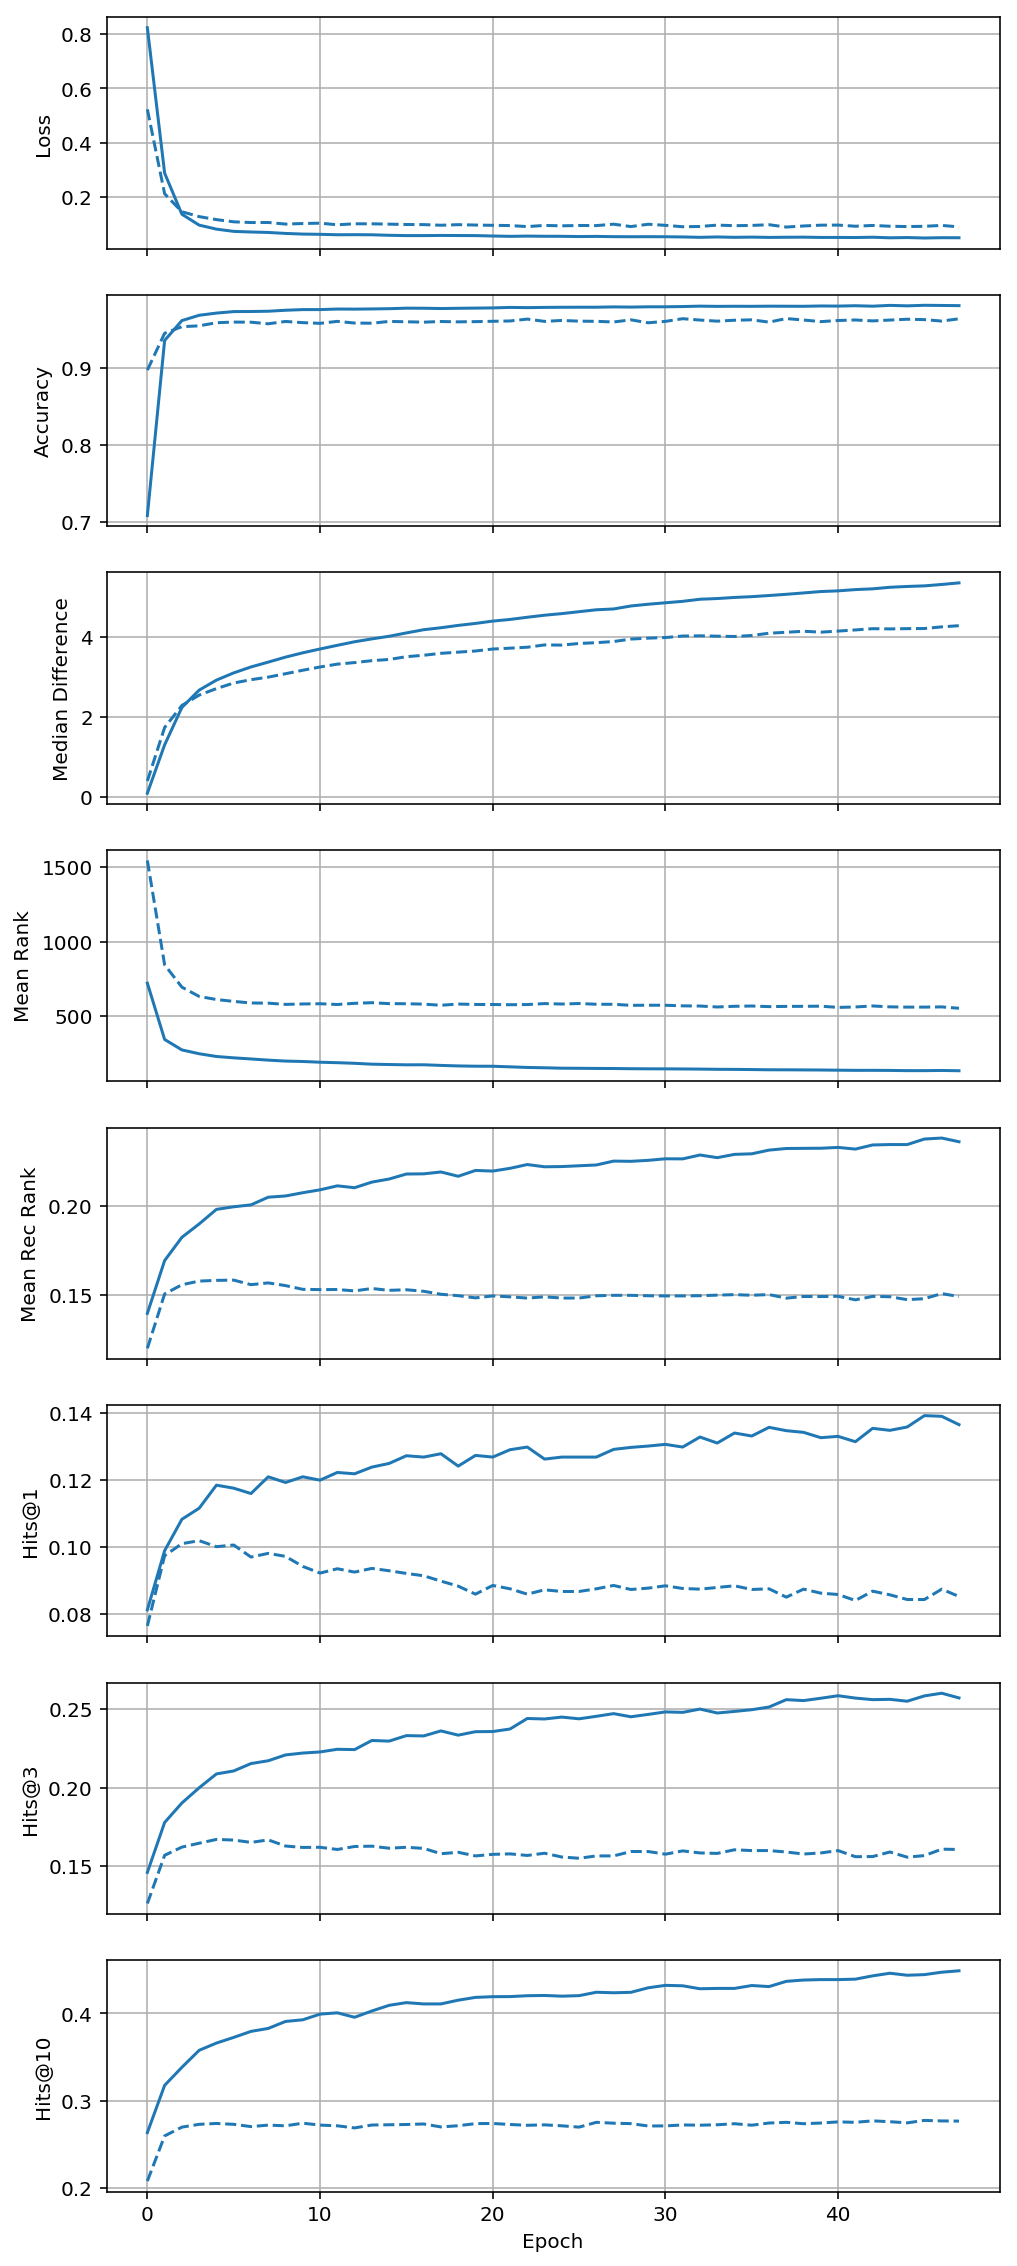

In [33]:
utils.History.load('logs/9_dist-mult-same-parameters.tsv').plot(*to_plot, figsize=figsize)

In [39]:
#history.save('logs/12_rgcn_new-one-hot-embedding_raw-ranking.tsv')

In [40]:
!ls logs

10_rgcn_new-ranking-algorithm_filtered-ranking-on-complete-val-set.tsv
11_dist-mult.tsv
12_rgcn_new-one-hot-embedding_raw-ranking.tsv
1_link-prediction-movielens-baseline.tsv
2_filtered-ranking-evaluation.tsv
3_directed-edges-in-adj-lists.tsv
4_batch-size-128-and-refactoring.tsv
5_sampling-over-all-relations-and-raw-ranking-and-undirected-edges.tsv
6_fb15k-237_embedding-size-200_batch-size-32_raw-ranking-over-300-samples.tsv
7_multiple-relations-per-edge_raw-ranking-over-5000-samples.tsv
8_train-test-split-for-adj-dict_actual-train-and-val-sets.tsv
9_dist-mult-same-parameters.tsv


# Calculate feature vectors for images

In [4]:
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image  # install pillow-simd instead of the default pillow version for a ~10 % speedup

In [5]:
image_model = models.vgg19_bn(pretrained=True)
image_model.classifier = nn.Sequential(*list(image_model.classifier.children())[:-1])  # remove last fully-connected layer
if torch.cuda.is_available():
    image_model.cuda()
image_model.eval();

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
images_root_dir = '../data/fb15k-237-onoro-rubio/image-graph_images'
feature_tensors_per_mid = {}

for mid in tqdm_notebook(os.listdir(images_root_dir)):
    if os.path.isdir(os.path.join(images_root_dir, mid)):
        #print(mid)
        img_tensors = []
        for filename in os.listdir(os.path.join(images_root_dir, mid)):
            try:
                img = Image.open(os.path.join(images_root_dir, mid, filename))
            except IOError:
                print('Could not read image:', os.path.join(images_root_dir, mid, filename))
            else:
                img_tensors.append(transform(img)[None])
        img_tensors = Variable(torch.cat(img_tensors), volatile=True)
        if torch.cuda.is_available():
            img_tensors = img_tensors.cuda()
        feature_tensors = image_model(img_tensors)
        feature_tensors_per_mid[mid] = feature_tensors.data.cpu().numpy()

HBox(children=(IntProgress(value=0, max=10222), HTML(value=u'')))

Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.0g5ptf/google_24.jpg
Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.06cmd2/bing_0.jpg
Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.01m4pc/google_14.jpg
Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.034bs/bing_13.jpg
Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.01j_9c/bing_24.jpg
Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.0cnl1c/google_0.jpg
Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.0cv_2/google_16.jpg
Could not read image: ../data/fb15k-237-onoro-rubio/image-graph_images/m.0f5xn/google_3.jpg



In [10]:
len(feature_tensors_per_mid)

10221

In [15]:
feature_tensors_per_mid.keys()[:5]

[u'm.0gcrg', u'm.01bl7g', u'm.0dwxr', u'm.0g28b1', u'm.01yqp']

In [19]:
feature_tensors_per_mid['m.0gcrg'][0]

0.19283886

In [13]:
# TDOO: Maybe save torch tensors directly. See how this compares to npz format in terms of file size.
#np.savez_compressed('../data/fb15k-237-onoro-rubio/feature-vectors-vgg19_bn.npz', **feature_tensors_per_mid)

In [24]:
!ls -lh '../data/fb15k-237-onoro-rubio/feature-vectors-vgg19_bn.npz'

-rw-rw-r-- 1 jrieke jrieke 4.7G Mar 25 05:18 ../data/fb15k-237-onoro-rubio/feature-vectors-vgg19_bn.npz


In [ ]:
# TODO: Implement this faster version with pytorch's DataSet and DataLoader.
image_dataset = datasets.ImageFolder(images_root_dir, transform=transform)
print(image_dataset.classes)
image_loader = DataLoader(image_dataset, batch_size=32, shuffle=False, num_workers=5, pin_memory=False)
for images, labels in tqdm_notebook(image_loader):
    images = Variable(images, volatile=True).cuda()
    feature_tensors = image_model(images).data.cpu().numpy()